# Autocorrelation Analysis

In [5]:
import scipy as sp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
%matplotlib inline
import autocorr as myutil
import warnings
warnings.filterwarnings('ignore')

In [6]:
import importlib
_ = importlib.reload(myutil)

## Get data and do preliminary preprocessing

In [7]:
dfx_train = myutil.get_indexed_dataset('data/dengue_features_train.csv')
dfy_train = myutil.get_indexed_dataset('data/dengue_labels_train.csv')
dfx_test = myutil.get_indexed_dataset('data/dengue_features_test.csv')
# combine training features with training labels for data exploration later on
dftrain = myutil.set_index(pd.merge(dfx_train, dfy_train))
# Will stack the train and test datasets to treat all NaN values together
# Need to add bogus total_cases column to test dataset so the files can be easily concatenated
# update total_cases = -1 to easily identify the records for later split data to original partitions
dfx_test['total_cases'] = -1
dfall = myutil.set_index(pd.concat((dftrain, dfx_test), axis=0))
dfall.sort_index(axis=0, inplace=True)
# drop unecessary columns and save column names
delcols = ['year','week_start_date','reanalysis_sat_precip_amt_mm','reanalysis_specific_humidity_g_per_kg']
dfall.drop(delcols, axis=1, inplace=True)
cols = dfall.columns
# remove NaNs
dfall = myutil.set_nan_to_week_mean(dfall.copy())

## One hot encode city and weekofyear

In [8]:
# split dataset and hot encode weekof year
dfall_copy = dfall.copy()
dfall_iq = dfall_copy[dfall_copy['city'] == 'iq']
dfall_sj = dfall_copy[dfall_copy['city'] == 'sj']
enc = OneHotEncoder(categorical_features=np.array([0]))
dset = dict()
dset['iq'] = enc.fit_transform(dfall_iq.iloc[:,1:].values).toarray()
dset['sj'] = enc.fit_transform(dfall_sj.iloc[:,1:].values).toarray()
dset['iq'].shape

(676, 72)

## Create several versions of the datasets (ADD total cases as ONLY feature)

In [9]:
# for each city, create version of datasets with 1 to 16 shifts (3 months)
for city in dset.keys():
    datashift = dict()
    for shift_no in range(2,18):
        # total cases is THE ONLY FEATURE
        datashift[shift_no-1] = myutil.shift(np.hstack((dset[city][:,-1:],dset[city][:,-1:])), shift_no)
    dset[city] = datashift

# for each city, each shift, create version of the dataset different scaling
for city in dset.keys():
    for shift_no in dset[city].keys():
        vers = dict()
        # save original as 'raw'
        vers['raw'] = np.hstack((dset[city][shift_no][:,:-1], dset[city][shift_no][:,-1:]))
        # save scaled with minmax in range [0,1] as 'minmax1'
        scaler = MinMaxScaler(feature_range=(0,1))
        vers['minmax1'] = np.hstack((scaler.fit_transform(dset[city][shift_no][:,:-1]), dset[city][shift_no][:,-1:]))
        # save scaled with minmax in range [0,1] as 'minmax1'
        # isolate features, so scaling will only affect features
        scaler = MinMaxScaler(feature_range=(-1,1))
        vers['minmax2'] = np.hstack((scaler.fit_transform(dset[city][shift_no][:,:-1]), dset[city][shift_no][:,-1:]))
        dset[city][shift_no] = vers
        
# for each city, each shift, each version, create X_train, y_train, and X_test partitions
dataset = dict()
for city in dset.keys():
    for shift_no in dset[city].keys():
        for vers in dset[city][shift_no].keys():
            npdata = dset[city][shift_no][vers]
            partition = dict()
            partition['X_train'] = npdata[npdata[:,-1]>0][:,:-1]
            partition['y_train'] = npdata[npdata[:,-1]>0][:,-1:]
            partition['X_test']  = npdata[npdata[:,-1]<0][:,:-1]
            id = city + '_' + str(shift_no) + '_' + vers
            dataset[id] = partition

In [11]:
#for key in dataset.keys():
#    print(key)

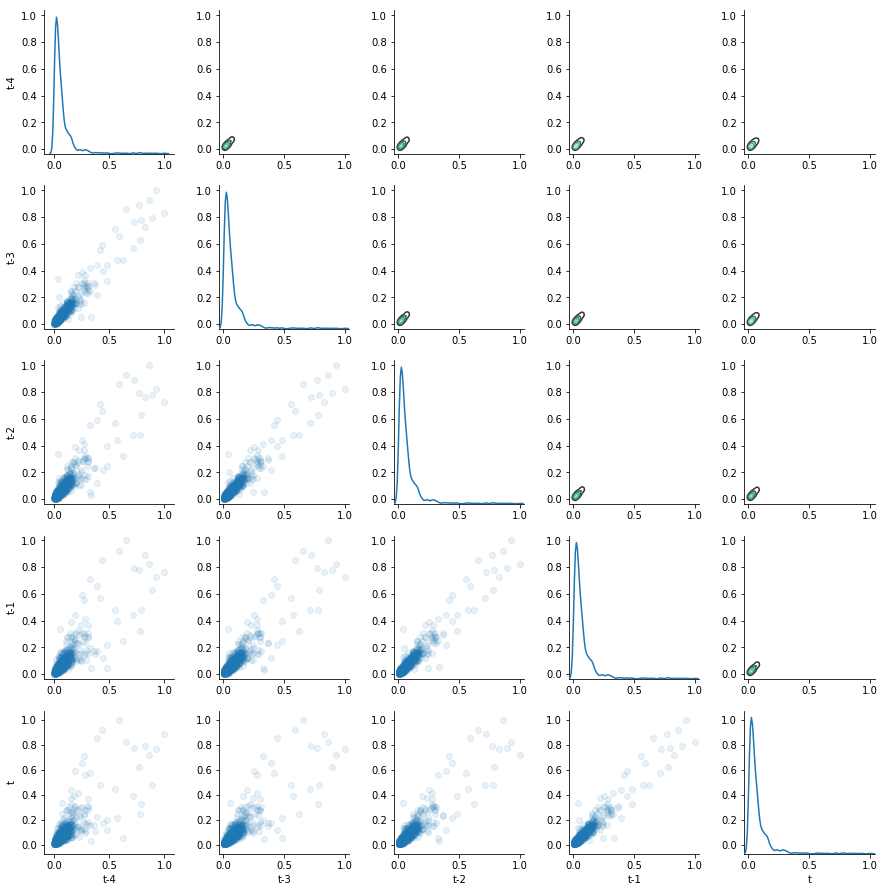

In [23]:
columns = [['t-4','t-3','t-2','t-1','t']]
df_sj = pd.DataFrame(dataset['sj_4_minmax1']['X_train'])
df_sj.columns = columns
g = sns.PairGrid(df_sj)
g.map_diag(sns.kdeplot)
g.map_lower(plt.scatter, alpha=0.1)
_ = g.map_upper(sns.kdeplot, n_levels=5)
plt.savefig('autocorr_sj.png')

In [24]:
df_sj.corr()

,t-4,t-3,t-2,t-1,t
t-4,1.000000,0.955233,0.909080,0.854673,0.798112
t-3,0.955233,1.000000,0.955238,0.909080,0.854669
t-2,0.909080,0.955238,1.000000,0.955237,0.909079
t-1,0.854673,0.909080,0.955237,1.000000,0.955236
t,0.798112,0.854669,0.909079,0.955236,1.000000


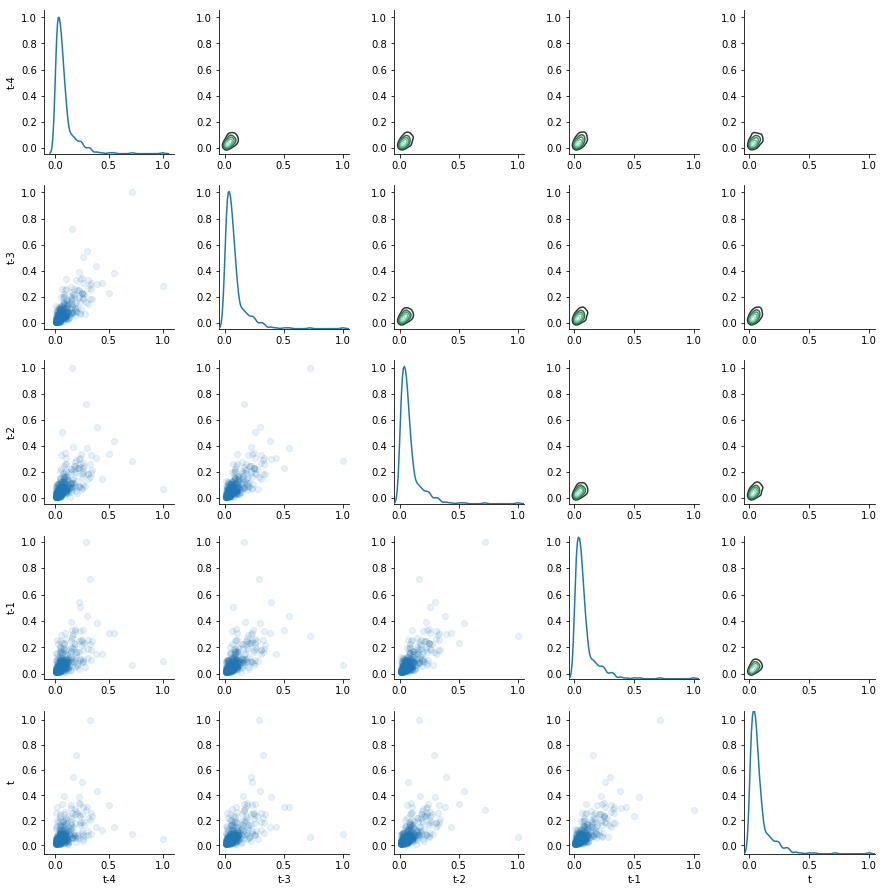

In [25]:
df_iq = pd.DataFrame(dataset['iq_4_minmax1']['X_train'])
df_iq.columns = columns
g = sns.PairGrid(df_iq)
g.map_diag(sns.kdeplot)
g.map_lower(plt.scatter, alpha=0.1)
_ = g.map_upper(sns.kdeplot, n_levels=5)
plt.savefig('autocorr_iq.png')

In [26]:
df_iq.corr()

,t-4,t-3,t-2,t-1,t
t-4,1.000000,0.725800,0.550666,0.505571,0.438564
t-3,0.725800,1.000000,0.723932,0.547935,0.506178
t-2,0.550666,0.723932,1.000000,0.722041,0.546579
t-1,0.505571,0.547935,0.722041,1.000000,0.721811
t,0.438564,0.506178,0.546579,0.721811,1.000000
